<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/09%20-%20Reaction%20properties/01_atom_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9: Reaction properties

Reaction property prediction is a crucial task, as it enables us to better understand chemical reactions and their outcomes. This not only contributes to the development of new chemical compounds and materials but also helps in streamlining the reaction process and reducing the time and resources required for experimentation.

Two significant aspects of reaction property prediction are `yield prediction` and `atom mapping`. Yield prediction refers to forecasting the amount of product generated by a particular chemical reaction. **Accurate yield prediction can help in optimizing reaction conditions, minimizing waste, and identifying the most efficient synthetic routes for a target molecule.** 

Atom mapping, on the other hand, is the process of determining the correspondence between atoms in the reactants and products of a chemical reaction. This information is essential for understanding the mechanism of the reaction and tracking the transformation of individual atoms during the reaction process. **Atom mapping plays a vital role in various applications, including reaction database management, reaction classification, and the development of reaction templates for computer-aided synthesis planning.**

# Atom mapping

In this notebook, we will explore some applications of atom mapping as well as one of the tools that exist for the calculation of this property.

In [1]:
! pip install rdkit rdchiral reaction-utils
! mkdir data/
! curl -L https://www.dropbox.com/sh/6ideflxcakrak10/AADN-TNZnuGjvwZYiLk7zvwra/schneider50k -o data/uspto50k.zip
! unzip data/uspto50k.zip -d data/
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/09%20-%20Reaction%20Properties/utils.py

  Using cached reaction_utils-1.2.0-py3-none-any.whl (49 kB)
  Using cached wrapt_timeout_decorator-1.3.12.2-py3-none-any.whl (21 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 11.6 MB/s eta 0:00:00a 0:00:01
  Using cached swifter-1.3.4.tar.gz (830 kB)
  Preparing metadata (setup.py) ... done
  Using cached py7zr-0.18.12-py3-none-any.whl (65 kB)
  Using cached metaflow-2.8.4-py2.py3-none-any.whl (923 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 25.9 MB/s eta 0:00:00
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
  Using cached multivolumefile-0.2.3-py3-none-any.whl (17 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.6 MB/s eta 0:00:00
  Using cached texttable-1.6.7-py2.py3-

In [6]:
from utils import *

# 0. Relevant packages 

## RXNMapper

RXNMapper is a deep learning tool for calculating the atom mapping for any reaction. This open-source tool uses the attention weights produced by a pretrained transformer model, and shows remarkable performance on atom mapping, compared to other tools available. This is an excellent example of the posible uses of unsupervised learning in chemistry. See more details [here](https://www.science.org/doi/10.1126/sciadv.abe4166).

## RDChiral

RDChiral is a wrapper for RDKit's functionalities for reaction handling, that improves stereochemistry handling. This package will allow us to extract `reaction templates` from a reaction dataset, which are a standard way of encoding **transformation rules**.

RDChiral then also lets us apply the `reaction template` to a target molecule, to discover the reactants that will afford the target molecule under the given transformation.

Learn more from [the code](https://github.com/connorcoley/rdchiral) and [the paper](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00286).

# 1. Obtaining the atom mapping

To obtain the atom mapping of a reaction, you can go to [this site](http://rxnmapper.ai/demo.html) and paste your reaction SMILES. The application will then show you the mapped reaction smiles, as well as some visualization options, including:

- The atom mapping of the reaction: which atoms in the reactants correspond to each atom in the products.

- The attention maps: What the underlying model is computing, that is the conection between each pair of tokens.


![image.png](rxnmapper.png)


## NOTE: This model is also accessible through a programming interface. For this, follow the instructions [here](https://github.com/rxn4chemistry/rxnmapper).

# TODO:

- [ ] Get a reaction and mapped rxn
- [ ] Get dataset of molecules
- [ ] Obtain possible reactant sets
- [ ] Get all reactant sets that can react like this, visualize

### Our task for this notebook will be to highlight reactions in a dataset, that may have some selectivity issues.

First, let's encode a generic aromatic substitution reaction as a reaction template.

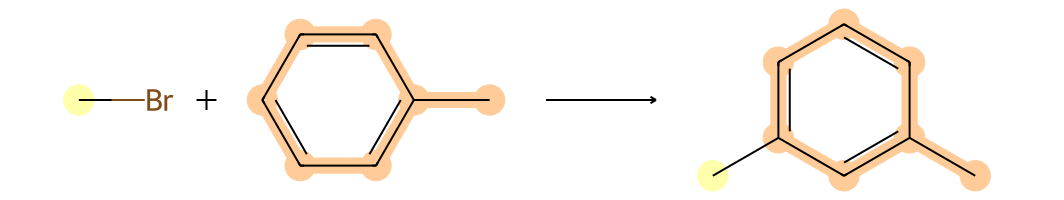

The reaction template looks like this: Br-[CH3;D1;+0:1].[cH;D2;+0:2]>>[CH3;D1;+0:1]-[c;H0;D3;+0:2]


In [21]:
gen_rxn = 'Br[CH3:1].[cH:2]1[cH:3][cH:4][cH:5][c:6]([CH3:7])[cH:8]1>>[CH3:1][c:2]1[cH:3][cH:4][cH:5][c:6]([CH3:7])[cH:8]1'
visualize_chemical_reaction(gen_rxn)

gen_template = extract_template(gen_rxn)
print(f'The reaction template looks like this: {gen_template}')

### Now, if we apply this template to the same set of reactants, we get multiple products.

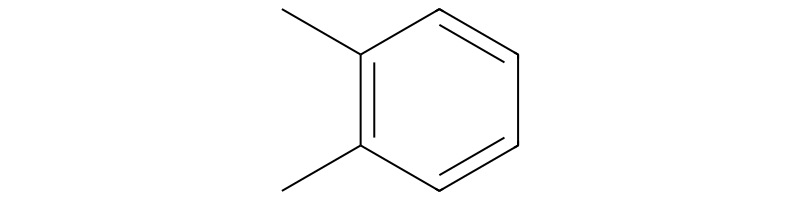

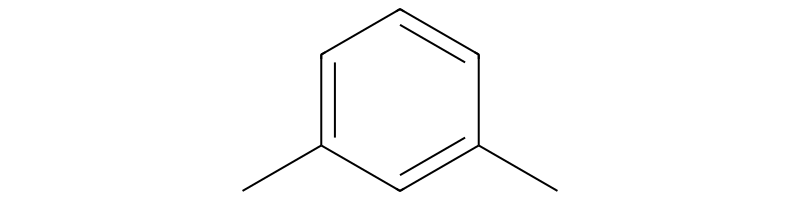

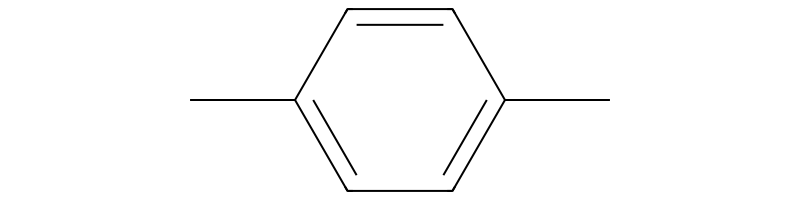

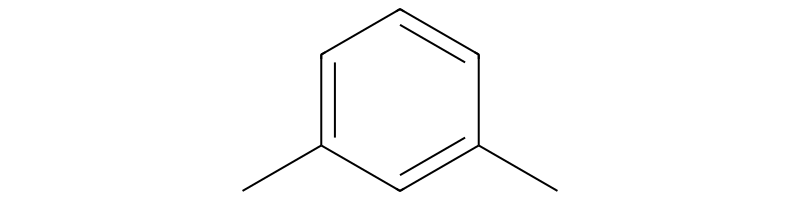

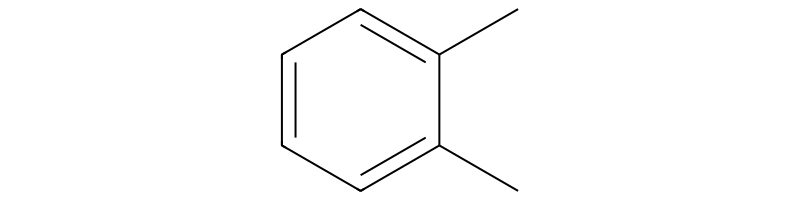

In [23]:
products = apply_template(gen_template, 'CBr.Cc1ccccc1')
for p in products:
    display(p[0])

### This highlights a potential selectivity issue in our reaction. What other reactions in USPTO have selectivity issues? This is important for model evaluation, sometimes models correctly predict a reaction type, but fail to predict the correct selectivity!

In [24]:
def remove_aam(smi):
    return canonicalize_smiles(re.sub(r"(?<=[^\*])(:\d+)]", "]", smi))

In [25]:
# Let's find all reactions in USPTO where this reaction template is valid

train_df, val_df, test_df = load_data()

# Get only reactants fro train set
train_reacts = train_df['reactants>reagents>production'].apply(lambda x: remove_aam(x.split('>>')[0]))
train_reacts

0        COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1        Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2        CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3        CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4        CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...
                               ...                        
40003    COC(=O)CCC(C(N)=O)N1Cc2c(OCc3ccc(CBr)cc3)cccc2...
40004                               COc1ccc2cc(Br)ccc2c1Br
40005                            CCC(O)CCCCCCC=CCCCCC(=O)O
40006    BrC(Br)(Br)Br.OCCCCCC1=C(c2ccc(O)cc2)CCCc2cc(O...
40007                      COC(=O)c1ccnc([N+](=O)[O-])c1.N
Name: reactants>reagents>production, Length: 40008, dtype: object


Potential selectivity issue found:


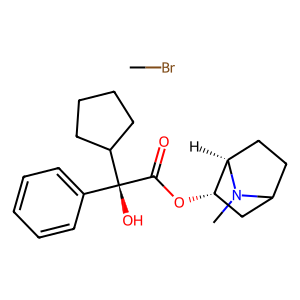

Possible products:


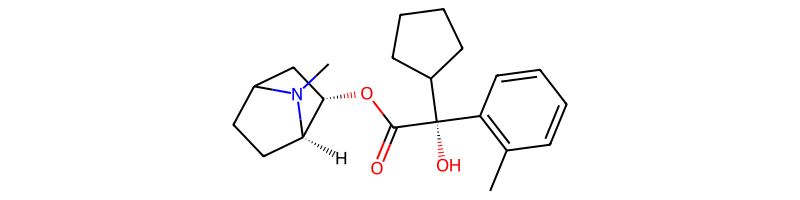

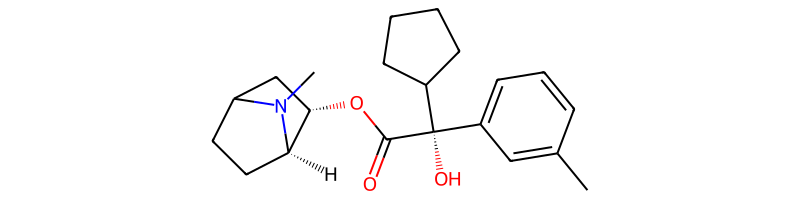

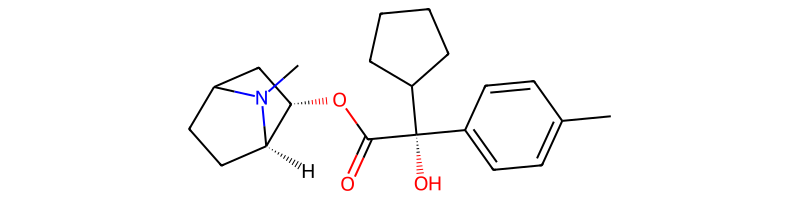

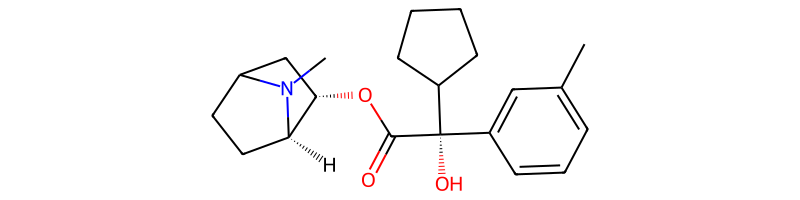

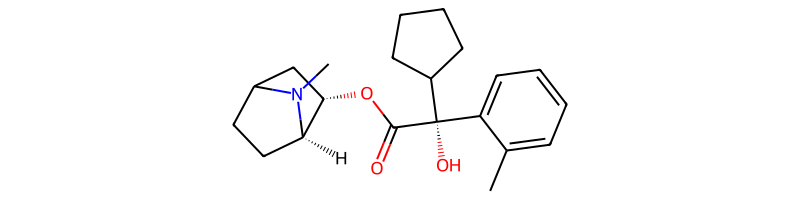


Potential selectivity issue found:


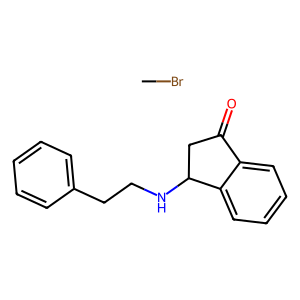

Possible products:


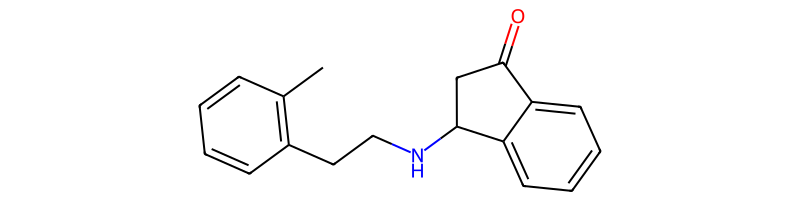

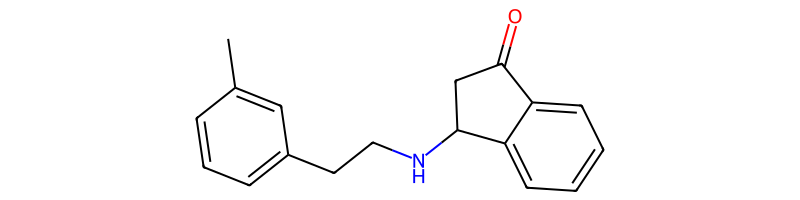

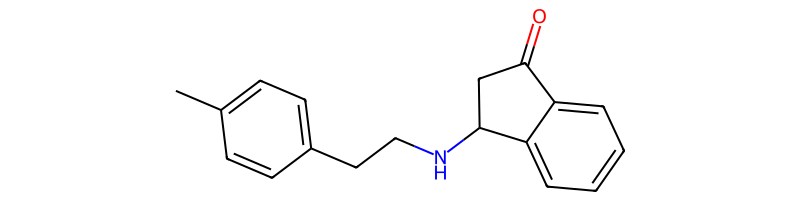

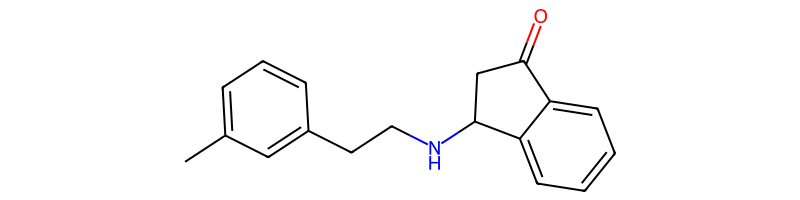

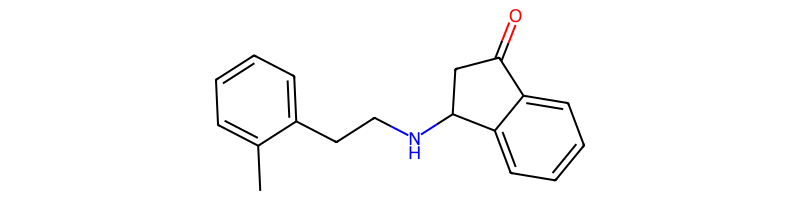

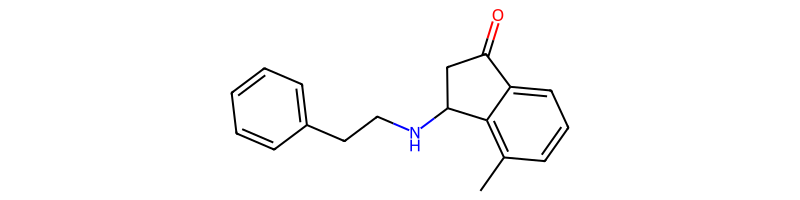

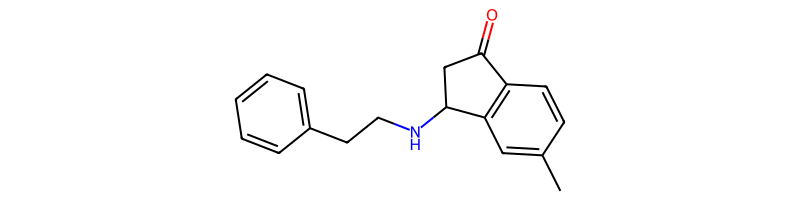

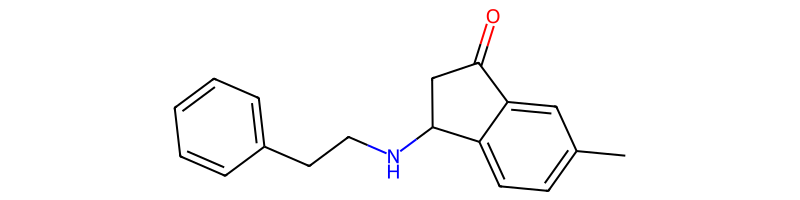

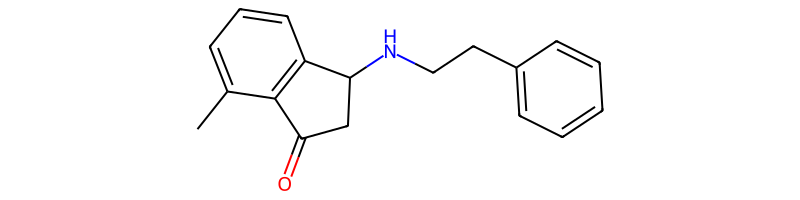

In [33]:
# Let's apply this template
for reacts in train_reacts:
    try:
        prod = apply_template(gen_template, reacts)
        if len(prod)>0:
            print('\nPotential selectivity issue found:')
            visualize_mols(reacts)
            print('Possible products:')
            for p in prod:
                display(p[0])
                
    except:
        continue